In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
import os
from model.pipeline import build_feature_matrix_and_target
from data_processing.split import split_member_time
from data_processing.grid_aggregate import conus_mean
from model.ednn_model import ednn_regressor_model
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from model.load_ednn_model import load_ednn_model, set_training_variance, predict_ednn
from mlguess.keras.models import EvidentialRegressorDNN
from mlguess.keras.losses import evidential_reg_loss
import xarray as xr
from data_processing.modis_lai import (
    load_modis_lai,
    normalize_longitudes,
    compute_lai_anomalies,
    compute_spatial_mean_anomaly)
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from matplotlib.ticker import FormatStrFormatter
from numpy import corrcoef
import calendar
from visualization.taylor_diagram import TaylorDiagram  # ensure this is on your PYTHONPATH

2025-08-05 14:02:11.748089: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 14:02:11.814827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 14:02:13.031601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load PPE and Meteo Anomalies Data 

In [2]:
#---------------- Build the full feature & target arrays
X, y = build_feature_matrix_and_target()

#---------------- Split & scale (returns 8 objects)
(
    X_train_xr, X_val_xr,
    y_train_xr, y_val_xr,
    X_train,    X_val,
    y_train,    y_val
) = split_member_time(X, y)

#---------------- Sanity‐check shapes
print("Full X, y shapes:         ", X.shape, y.shape)
print("X_train_xr, X_val_xr:     ", X_train_xr.shape, X_val_xr.shape)
print("X_train, X_val:           ", X_train.shape, X_val.shape)
print("y_train_xr, y_val_xr:     ", y_train_xr.shape, y_val_xr.shape)
print("y_train, y_val:           ", y_train.shape, y_val.shape)

IOStream.flush timed out


Full X, y shapes:          (19836000, 37) (19836000,)
X_train_xr, X_val_xr:      (13780800, 37) (522000, 37)
X_train, X_val:            (13780800, 37) (522000, 37)
y_train_xr, y_val_xr:      (13780800,) (522000,)
y_train, y_val:            (13780800, 1) (522000, 1)


### Load Model

In [3]:
model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
model_path   = f"{model_folder}/ednn_reg_model.keras"
loss_weight  = 1e-10#1e-10   # match what you trained with

model = load_ednn_model(model_path, loss_weight)
set_training_variance(model, y_train)
p_wu_val, p_wo_val = predict_ednn(model, X_val)

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


### Convert to Xarray

In [4]:
#---------------- Wrap train predictions back to xarray and unstack
param_names = ["mu","nu","alpha","beta"]

#---------------- Wrap validation predictions back to xarray and unstack
pred_val_ds = xr.Dataset(
    { name: (("sample",), p_wo_val[:, i]) 
      for i, name in enumerate(param_names) },
    coords={"sample": y_val_xr.coords["sample"]}
)

pred_val_ds["TLAI_unc"] = xr.DataArray(
    p_wu_val,
    dims=("sample","uncertainty"),
    coords={
      "sample":      y_val_xr.coords["sample"],
      "uncertainty": ["mean","aleatoric","epistemic"]
    },
    name="TLAI_uncertainties"
)

pred_val_3d = pred_val_ds.unstack("sample")

#---------------- Inspect
print("VALIDATION PREDICTIONS:", pred_val_3d)

VALIDATION PREDICTIONS: <xarray.Dataset>
Dimensions:      (member: 100, time: 180, gridcell: 29, uncertainty: 3)
Coordinates:
  * member       (member) int64 401 402 403 404 405 406 ... 496 497 498 499 500
  * time         (time) object 2000-01-01 00:00:00 ... 2014-12-01 00:00:00
  * gridcell     (gridcell) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * uncertainty  (uncertainty) <U9 'mean' 'aleatoric' 'epistemic'
Data variables:
    mu           (member, time, gridcell) float32 0.09515 0.1466 ... 0.3086
    nu           (member, time, gridcell) float32 0.5889 0.3522 ... 1.582 1.566
    alpha        (member, time, gridcell) float32 1.006 1.035 ... 1.209 1.132
    beta         (member, time, gridcell) float32 0.005065 0.006217 ... 0.02043
    TLAI_unc     (uncertainty, member, time, gridcell) float32 0.09515 ... 0....


### Compute CONUS Gridcells Mean

In [5]:
lai_glob = "/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI/*.nc"
land_area_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/sparsegrid_landarea.nc"
#------------- Load land area
land_area = xr.open_dataset(land_area_path).landarea

In [6]:
y_val_3d = y_val_xr.unstack("sample")
pred_val_3d = conus_mean(pred_val_3d, land_area)
y_val_3d = conus_mean(y_val_3d, land_area)

In [7]:
pred_val_3d

<xarray.Dataset>
Dimensions:      (member: 100, time: 180, uncertainty: 3)
Coordinates:
  * member       (member) int64 401 402 403 404 405 406 ... 496 497 498 499 500
  * time         (time) object 2000-01-01 00:00:00 ... 2014-12-01 00:00:00
  * uncertainty  (uncertainty) <U9 'mean' 'aleatoric' 'epistemic'
Data variables:
    mu           (member, time) float64 0.1059 -0.07753 ... 0.5732 0.4706
    nu           (member, time) float64 1.261 2.312 1.326 ... 1.463 1.664 0.8356
    alpha        (member, time) float64 1.092 1.06 1.156 ... 1.284 1.56 2.553
    beta         (member, time) float64 0.05134 0.04352 ... 0.4032 0.6581
    TLAI_unc     (uncertainty, member, time) float64 0.1059 -0.07753 ... 0.7918

### Compute MODIS Anomalies 

Loaded dataset with dimensions: Frozen({'lon': 3600, 'lat': 1800, 'time': 180})
Variables: ['lai']
CONUS LAI shape: Frozen({'time': 180, 'lat': 250, 'lon': 590})
<xarray.DataArray 'lai' (time: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2014-12-01


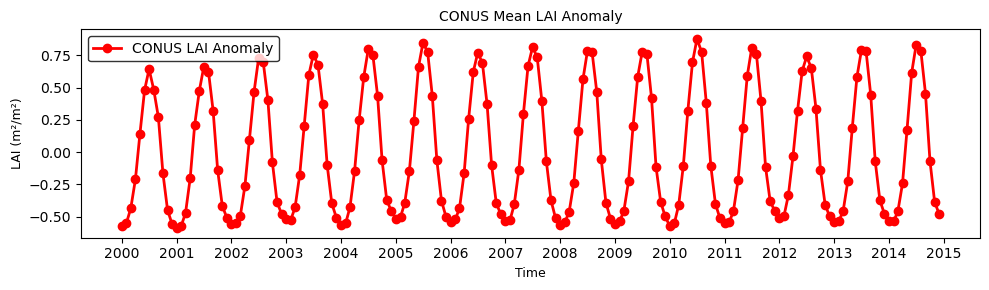

In [8]:
#-------------------------------
# Define file pattern & CONUS bounds
#-------------------------------
PATTERN = "/bsuhome/ksilwimba/scratch/emulation_with_forcing/observation_data/lai_monthly_0.1_20*.nc"
CONUS_BOUNDS = dict(
    min_lon=235,
    max_lon=294,
    min_lat=24.5,
    max_lat=49.5,
)

#-------------------------------
# Load and fix time coordinates
#-------------------------------
ds = load_modis_lai(PATTERN)
print("Loaded dataset with dimensions:", ds.sizes)
print("Variables:", list(ds.data_vars))

#-------------------------------
# Normalize longitudes & ensure ascending latitude
#-------------------------------
ds = normalize_longitudes(ds).sortby("lat")

#-------------------------------
# Subset to CONUS region
#-------------------------------
ds_conus = ds.sel(
    lon=slice(CONUS_BOUNDS['min_lon'], CONUS_BOUNDS['max_lon']),
    lat=slice(CONUS_BOUNDS['min_lat'], CONUS_BOUNDS['max_lat'])
)
print(f"CONUS LAI shape: {ds_conus['lai'].sizes}")

#-------------------------------
# Compute gridcell anomalies
#-------------------------------
anom = compute_lai_anomalies(ds_conus)

#-------------------------------
# Compute spatial mean anomaly time series
#-------------------------------
ts = compute_spatial_mean_anomaly(anom)
print(ts)

#-------------------------------
# Plot CONUS LAI anomaly time series
#-------------------------------

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(
    ts['time'],
    ts,
    marker='o',
    linestyle='-',
    linewidth=2,
    color='r',
    label='CONUS LAI Anomaly'
)
ax.set_title('CONUS Mean LAI Anomaly', fontsize=10, fontweight='regular')
ax.set_xlabel('Time', fontsize=9)
ax.set_ylabel('LAI (m²/m²)', fontsize=9)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# fig.autofmt_xdate(ha='right')
# ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

# EDNN Model Performance on Unseen CLM5-PPE Ensemble Members

In [9]:
clm5_lai_ppe_anom = y_val_3d#.mean(dim="gridcell")            # dims (member, time)
ednn_ppe_lai_anom = pred_val_3d["mu"]#.mean(dim="gridcell")  # dims (member, time
time_cftime = ednn_ppe_lai_anom.time.values
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in time_cftime
]) 

In [10]:
figure_path = "/bsuhome/ksilwimba/scratch/emulation_with_forcing/clm5-lai-ppe-ednn/ednn-paper-code/Figures"

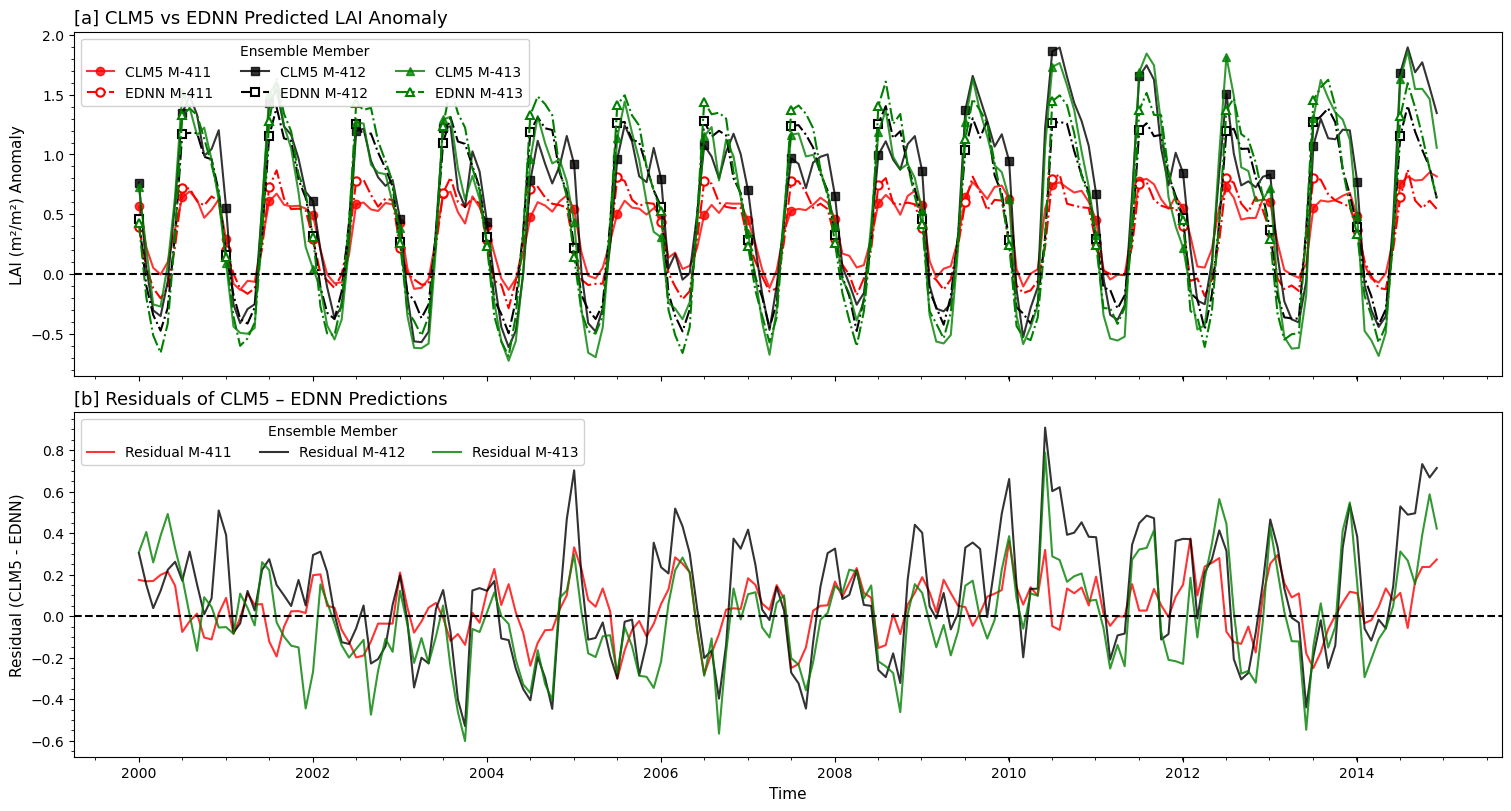

In [11]:
# Convert xarray time coordinate to pandas DateTimeIndex
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in clm5_lai_ppe_anom.time.values
])
#----------------- Select a subset of ensemble members for plotting
members = clm5_lai_ppe_anom.member.values[10:13]

#-------------------------------
# Cell: Define Colors & Markers
#-------------------------------
palette = ['red', 'black', 'green']
markers = ['o', 's', '^']
member_colors = {m: palette[i] for i, m in enumerate(members)}
member_markers = {m: markers[i] for i, m in enumerate(members)}

#-------------------------------
# Cell: Plot Time Series & Residuals
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(15, 8),
    sharex=True,
    constrained_layout=True
)

#----------------- (a) CLM5 vs EDNN Predicted LAI Anomaly
ax1.set_title(
    "[a] CLM5 vs EDNN Predicted LAI Anomaly",
    fontsize=13,
    loc='left'
)
ax1.set_ylabel("LAI (m²/m²) Anomaly", fontsize=11)
ax1.minorticks_on()
for m in members:
    #----------------- True values: solid line
    ax1.plot(
        time_idx,
        clm5_lai_ppe_anom.sel(member=m),
        label=f"CLM5 M-{m}",
        color=member_colors[m],
        marker=member_markers[m],
        linestyle='-',
        linewidth=1.5,
        markersize=6,
        alpha=0.8,
        markevery=6
    )
    #----------------- Predicted values: dashdot
    ax1.plot(
        time_idx,
        ednn_ppe_lai_anom.sel(member=m),
        label=f"EDNN M-{m}",
        color=member_colors[m],
        marker=member_markers[m],
        linestyle='dashdot',
        linewidth=1.5,
        markersize=6,
        markerfacecolor='white',
        markeredgewidth=1.5,
        alpha=1,
        markevery=6
    )
ax1.axhline(0, color='black', linestyle='--')
ax1.legend(
    title='Ensemble Member',
    title_fontsize=10,
    fontsize=10,
    loc='upper left',
    frameon=True,
    framealpha=0.9,
    ncol=3
)

#----------------- (b) Residuals: CLM5 minus EDNN
ax2.set_title(
    "[b] Residuals of CLM5 – EDNN Predictions",
    fontsize=13,
    loc='left'
)
ax2.set_xlabel("Time", fontsize=11)
ax2.set_ylabel("Residual (CLM5 - EDNN)", fontsize=11)
ax2.minorticks_on()
for m in members:
    residuals = (
        clm5_lai_ppe_anom.sel(member=m)
        - ednn_ppe_lai_anom.sel(member=m)
    )
    ax2.plot(
        time_idx,
        residuals,
        label=f"Residual M-{m}",
        color=member_colors[m],
        alpha=0.8
    )
ax2.axhline(0, color='black', linestyle='--')
ax2.legend(
    title='Ensemble Member',
    title_fontsize=10,
    fontsize=10,
    loc='upper left',
    frameon=True,
    framealpha=0.9,
    ncol=3
)
# plt.tight_layout()
plt.savefig(figure_path+"/TLAI_timeseries_with_residuals.pdf", bbox_inches='tight')
plt.show()

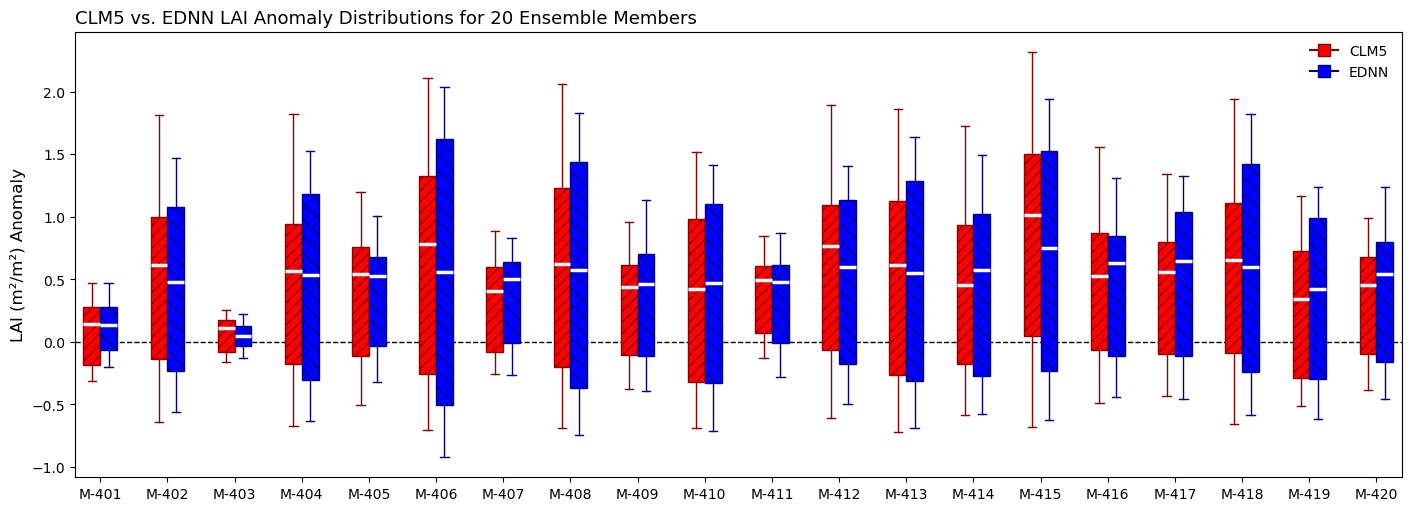

In [12]:
#-------------------------------
#Data Preparation
#-------------------------------
#------------------------------- Select first 20 ensemble members
members = clm5_lai_ppe_anom.member.values[:20]

#------------------------------- Extract anomalies for CLM5 and EDNN per member
clm5_data = [clm5_lai_ppe_anom.sel(member=m).values for m in members]
ednn_data = [ednn_ppe_lai_anom.sel(member=m).values for m in members]

#-------------------------------
# Plot Configuration
#-------------------------------
n = len(members)
width = 0.5
x_positions = np.arange(n) * 2.0
pos_clm5 = x_positions
pos_ednn = x_positions + width

#------------------------------- Define hatch and color properties
color_clm5 = {'face': 'red', 'edge': 'darkred', 'hatch': '///'}
color_ednn = {'face': 'blue', 'edge': 'navy', 'hatch': '\\\\'}

# Prepare legend handles
legend_handles = [
    mlines.Line2D([], [], color=color_clm5['edge'], marker='s', markersize=8,
                  markerfacecolor=color_clm5['face'], markeredgecolor=color_clm5['edge'],
                  label='CLM5'),
    mlines.Line2D([], [], color=color_ednn['edge'], marker='s', markersize=8,
                  markerfacecolor=color_ednn['face'], markeredgecolor=color_ednn['edge'],
                  label='EDNN')
]

#-------------------------------
# Create Boxplots
#-------------------------------
fig, ax = plt.subplots(figsize=(14, 5), constrained_layout=True)

#------------------------------- CLM5 boxplot
ax.boxplot(
    clm5_data,
    positions=pos_clm5,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=color_clm5['face'], edgecolor=color_clm5['edge'], hatch=color_clm5['hatch']),
    medianprops=dict(color='white', linewidth=2.5),
    whiskerprops=dict(color=color_clm5['edge']),
    capprops=dict(color=color_clm5['edge']),
    flierprops=dict(marker='o', markerfacecolor=color_clm5['edge'], markeredgecolor=color_clm5['edge'],
                    markersize=4, linestyle='none', alpha=0.5)
)

#----------------------- EDNN boxplot
ax.boxplot(
    ednn_data,
    positions=pos_ednn,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor=color_ednn['face'], edgecolor=color_ednn['edge'], hatch=color_ednn['hatch']),
    medianprops=dict(color='white', linewidth=2.5),
    whiskerprops=dict(color=color_ednn['edge']),
    capprops=dict(color=color_ednn['edge']),
    flierprops=dict(marker='o', markerfacecolor=color_ednn['edge'], markeredgecolor=color_ednn['edge'],
                    markersize=4, linestyle='none', alpha=0.5)
)

#-------------------------------
# Finalize Plot
#-------------------------------
#----------------------- Centered x-axis labels
ax.set_xticks(x_positions + width / 2)
ax.set_xticklabels([f"M-{m}" for m in members], fontsize=10)

#----------------------- Axis labels and title
ax.set_ylabel("LAI (m²/m²) Anomaly", fontsize=12)
ax.set_title(
    "CLM5 vs. EDNN LAI Anomaly Distributions for 20 Ensemble Members",
    fontsize=13,
    loc='left'
)

#----------------------- Zero reference line behind boxes
tmp_zorder = ax.get_zorder()
ax.axhline(0, color='black', linestyle='--', linewidth=1, zorder=tmp_zorder-1)

#----------------------- Legend
ax.legend(handles=legend_handles, loc='upper right', frameon=False, fontsize=10)

#----------------------- Save and show
plt.savefig(f"{figure_path}/ensemble_member_boxplots_hatched.pdf", bbox_inches='tight')
plt.show()


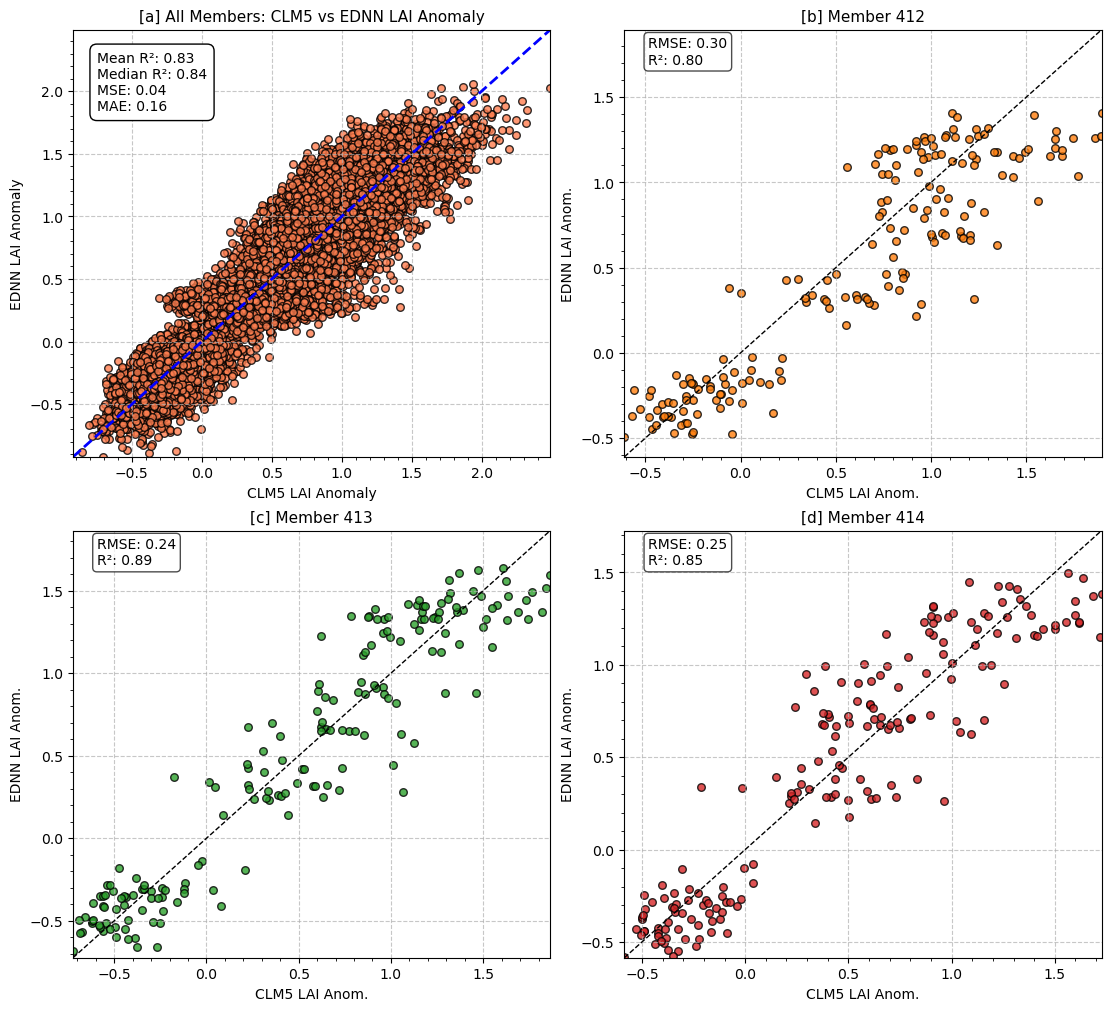

In [13]:
#-------------------------------
# Data Preparation
#-------------------------------
#------------------------------- Flatten all ensemble-member anomalies for overall scatter
data_true = clm5_lai_ppe_anom.values.flatten()
data_pred = ednn_ppe_lai_anom.values.flatten()

#------------------------------- Select four members to plot (using indices 10–13)
members_to_plot = clm5_lai_ppe_anom.member.values[10:14]

# Convert xarray time coordinate to pandas DateTimeIndex
time_idx = pd.to_datetime([
    f"{t.year}-{t.month:02d}-{t.day:02d}" for t in clm5_lai_ppe_anom.time.values
])

#-------------------------------
# Compute Statistics
#-------------------------------
#------------------------------- Overall metrics across all members
total_mse = mean_squared_error(data_true, data_pred)
total_mae = mean_absolute_error(data_true, data_pred)
r2_all = r2_score(data_true, data_pred)

#------------------------------- Per-member R² for annotation in first subplot
r2_per_member = [
    r2_score(
        clm5_lai_ppe_anom.sel(member=m).values,
        ednn_ppe_lai_anom.sel(member=m).values
    ) for m in clm5_lai_ppe_anom.member.values
]
mean_r2 = np.mean(r2_per_member)
median_r2 = np.median(r2_per_member)

#------------------------------- Scatter plot axis limits based on data range
vmin = min(data_true.min(), data_pred.min())
vmax = max(data_true.max(), data_pred.max())

#-------------------------------
# Create 2×2 Scatter Grid
#-------------------------------
fig, axs = plt.subplots(
    2, 2,
    figsize=(11, 10),
    constrained_layout=True
)

#------------------------------- Subplot [a]: All-members scatter
ax = axs[0, 0]
ax.scatter(
    data_true, data_pred,
    color='coral', edgecolor='black', s=30, alpha=0.8
)
ax.plot([vmin, vmax], [vmin, vmax], linestyle='--', color='blue', linewidth=2)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_title('[a] All Members: CLM5 vs EDNN LAI Anomaly', fontsize=11)
ax.set_xlabel('CLM5 LAI Anomaly', fontsize=10)
ax.set_ylabel('EDNN LAI Anomaly', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.minorticks_on()
#------------------------------- Annotate overall stats
ax.text(
    0.05, 0.95,
    f"Mean R²: {mean_r2:.2f}\n"
    f"Median R²: {median_r2:.2f}\n"
    f"MSE: {total_mse:.2f}\n"
    f"MAE: {total_mae:.2f}",
    transform=ax.transAxes,
    va='top', ha='left', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

#------------------------------- Subplots [b-d]: Individual member scatter with RMSE and R²
for idx, m in enumerate(members_to_plot[1:], start=1):
    ax = axs.flat[idx]
    true_vals = clm5_lai_ppe_anom.sel(member=m).values
    pred_vals = ednn_ppe_lai_anom.sel(member=m).values

    #------------------------------- Member-specific metrics
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    r2_m = r2_score(true_vals, pred_vals)

    #------------------------------- Scatter and 1:1 line
    ax.scatter(
        true_vals, pred_vals,
        color=plt.cm.tab10(idx), edgecolor='black', s=30, alpha=0.8
    )
    lims = [
        min(true_vals.min(), pred_vals.min()),
        max(true_vals.max(), pred_vals.max())
    ]
    ax.plot(lims, lims, linestyle='--', color='black', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    #------------------------------- Annotations and titles
    ax.set_title(f"[{chr(96+idx+1)}] Member {m}", fontsize=11)
    ax.set_xlabel('CLM5 LAI Anom.', fontsize=10)
    ax.set_ylabel('EDNN LAI Anom.', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.minorticks_on()

    ax.text(
        lims[0] + 0.05*(lims[1]-lims[0]),
        lims[1] - 0.08*(lims[1]-lims[0]),
        f"RMSE: {rmse:.2f}\nR²: {r2_m:.2f}",
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

#-------------------------------
# Save and Show
#-------------------------------
plt.savefig(f"{figure_path}/scatterplot_combined.pdf", bbox_inches='tight')
plt.show()

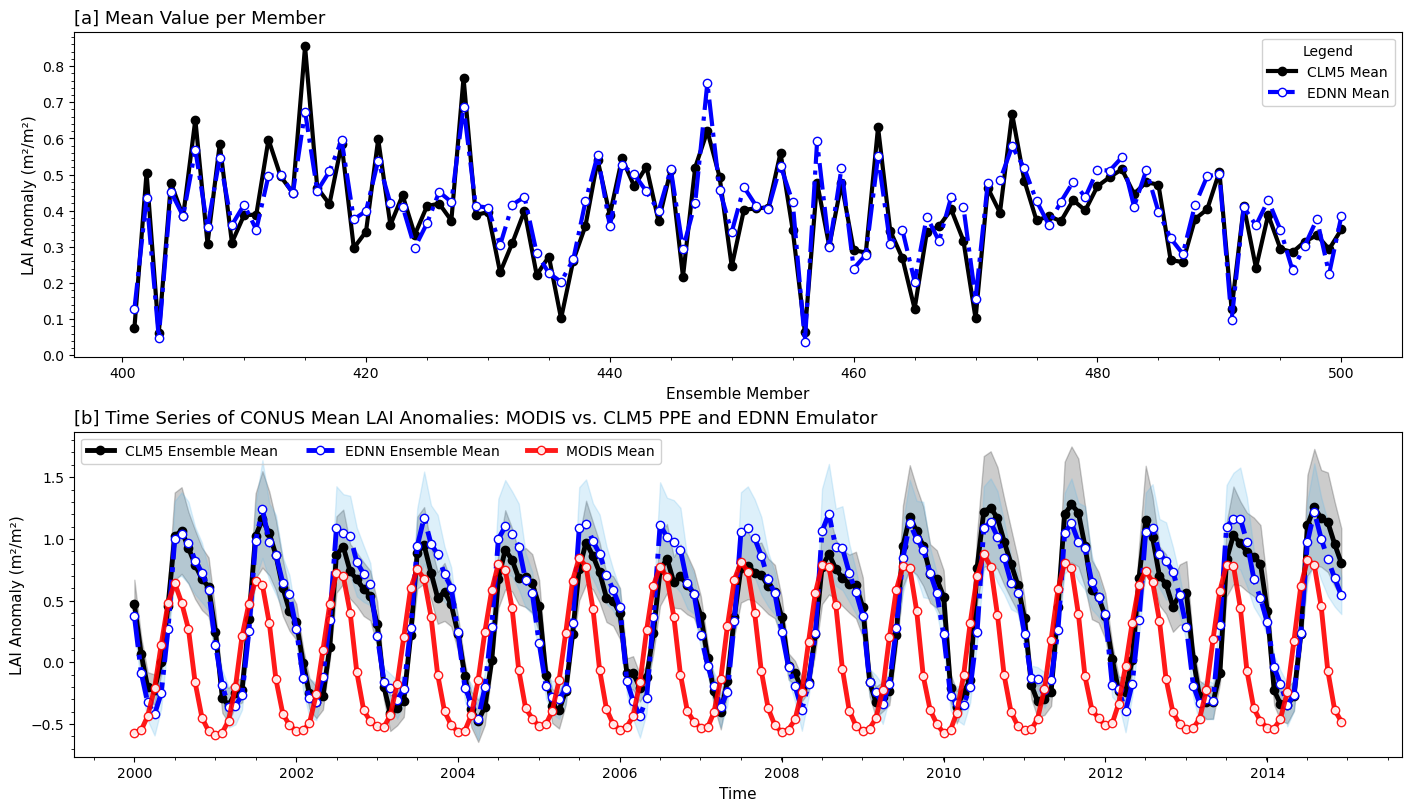

In [14]:
#-------------------------------
# Compute Summary Statistics
#-------------------------------
#------------------------------- Per-member statistics over time
data_clm5_member_mean = clm5_lai_ppe_anom.mean(dim='time')
data_clm5_member_std  = clm5_lai_ppe_anom.std(dim='time')
data_ednn_member_mean = ednn_ppe_lai_anom.mean(dim='time')
data_ednn_member_std  = ednn_ppe_lai_anom.std(dim='time')

#------------------------------- Ensemble statistics over members for each time step
data_clm5_ens_mean = clm5_lai_ppe_anom.mean(dim='member')
data_clm5_ens_std  = clm5_lai_ppe_anom.std(dim='member')
data_ednn_ens_mean = ednn_ppe_lai_anom.mean(dim='member')
data_ednn_ens_std  = ednn_ppe_lai_anom.std(dim='member')

#-------------------------------
# Cell: Setup Figure and Axes
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    constrained_layout=True
)

#-------------------------------
# [a] Mean per Member
#-------------------------------
members = clm5_lai_ppe_anom.member.values
ax1.plot(
    members,
    data_clm5_member_mean,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    linewidth=3,
    label='CLM5 Mean'
)
ax1.plot(
    members,
    data_ednn_member_mean,
    linestyle='dashdot',
    color='blue',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3,
    label='EDNN Mean'
)
ax1.set_title('[a] Mean Value per Member', loc='left', fontsize=13)
ax1.set_xlabel('Ensemble Member', fontsize=11)
ax1.set_ylabel('LAI Anomaly (m²/m²)', fontsize=11)
ax1.legend(frameon=True, framealpha=0.9, fontsize=10, title='Legend')
ax1.minorticks_on()

#-------------------------------
# [b] Ensemble Mean Over Time (with Observations)
#-------------------------------
time = time_idx  # pandas.DatetimeIndex
modis_series = ts    # observed MODIS CONUS mean anomaly

#------------------------------- CLM5 ensemble mean + ±1σ
ax2.plot(
    time,
    data_clm5_ens_mean,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    linewidth=3.5,
    label='CLM5 Ensemble Mean'
)
ax2.fill_between(
    time,
    data_clm5_ens_mean - data_clm5_ens_std,
    data_clm5_ens_mean + data_clm5_ens_std,
    color='black',
    alpha=0.2
)

#------------------------------- EDNN ensemble mean + ±1σ
ax2.plot(
    time,
    data_ednn_ens_mean,
    linestyle='dashdot',
    color='blue',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3.5,
    label='EDNN Ensemble Mean'
)
ax2.fill_between(
    time,
    data_ednn_ens_mean - data_ednn_ens_std,
    data_ednn_ens_mean + data_ednn_ens_std,
    color='#56B4E9',
    alpha=0.2
)

#------------------------------- MODIS CONUS observation
ax2.plot(
    time,
    modis_series,
    linestyle='-',
    color='red',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    linewidth=3.5,
    alpha=0.9,
    label='MODIS Mean'
)

ax2.set_title(
    '[b] Time Series of CONUS Mean LAI Anomalies: MODIS vs. CLM5 PPE and EDNN Emulator',
    loc='left', fontsize=13
)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('LAI Anomaly (m²/m²)', fontsize=11)
ax2.legend(
    loc='upper left',
    ncol=3,
    frameon=True,
    framealpha=0.9,
    title_fontsize=12,
    fontsize=10,
    facecolor='none'
)
ax2.minorticks_on()

#-------------------------------
# Save and Show
#-------------------------------
plt.savefig(f"{figure_path}/TLAI_mean_with_obs.pdf", bbox_inches='tight')
plt.show()

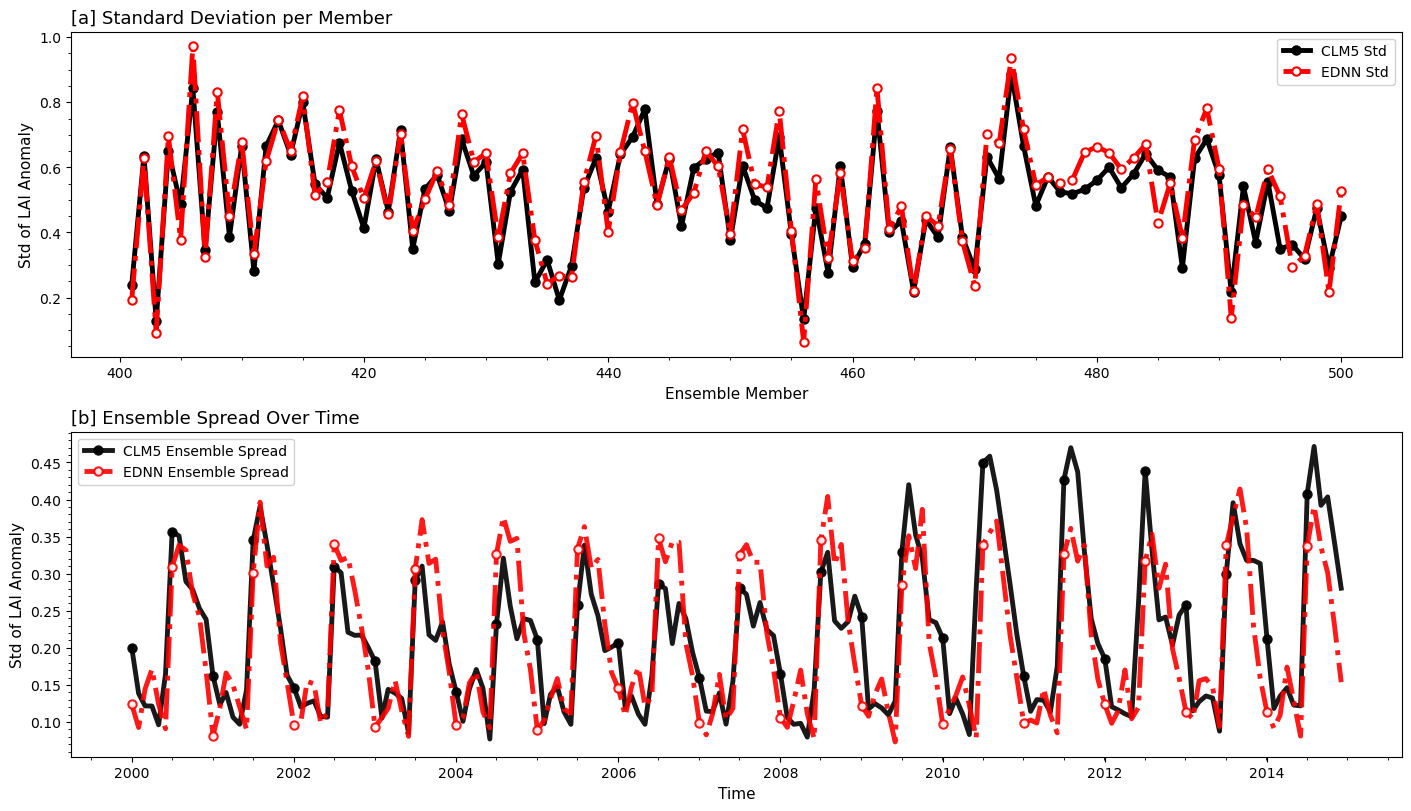

In [15]:
#-------------------------------
# Plot Standard Deviations and Ensemble Spread
#-------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    constrained_layout=True
)

#------------------------------- [a] Standard Deviation per Member
ax1.plot(
    members,
    data_clm5_member_std,
    linestyle='-',
    color='black',
    marker='o',
    markersize=6,
    markeredgewidth=1.5,
    linewidth=3.5,
    label='CLM5 Std'
)
ax1.plot(
    members,
    data_ednn_member_std,
    linestyle='dashdot',
    color='red',
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5,
    linewidth=3.5,
    label='EDNN Std'
)
ax1.set_title('[a] Standard Deviation per Member', loc='left', fontsize=13)
ax1.set_xlabel('Ensemble Member', fontsize=11)
ax1.set_ylabel('Std of LAI Anomaly', fontsize=11)
ax1.legend(fontsize=10, frameon=True, framealpha=0.9)
ax1.minorticks_on()

#------------------------------- [b] Ensemble Spread Over Time
ax2.plot(
    time_idx,
    data_clm5_ens_std,
    linestyle='-',
    color='black',
    marker='o',
    markevery=6,
    markersize=6,
    markeredgewidth=1.5,
    linewidth=3.5,
    alpha=0.9,
    label='CLM5 Ensemble Spread'
)
ax2.plot(
    time_idx,
    data_ednn_ens_std,
    linestyle='dashdot',
    color='red',
    marker='o',
    markevery=6,
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=1.5,
    linewidth=3.5,
    alpha=0.9,
    label='EDNN Ensemble Spread'
)
ax2.set_title('[b] Ensemble Spread Over Time', loc='left', fontsize=13)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_ylabel('Std of LAI Anomaly', fontsize=11)
ax2.legend(fontsize=10, loc='upper left', frameon=True, framealpha=0.9)
ax2.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.savefig(f"{figure_path}/TLAI_std.pdf", bbox_inches='tight')
plt.show()

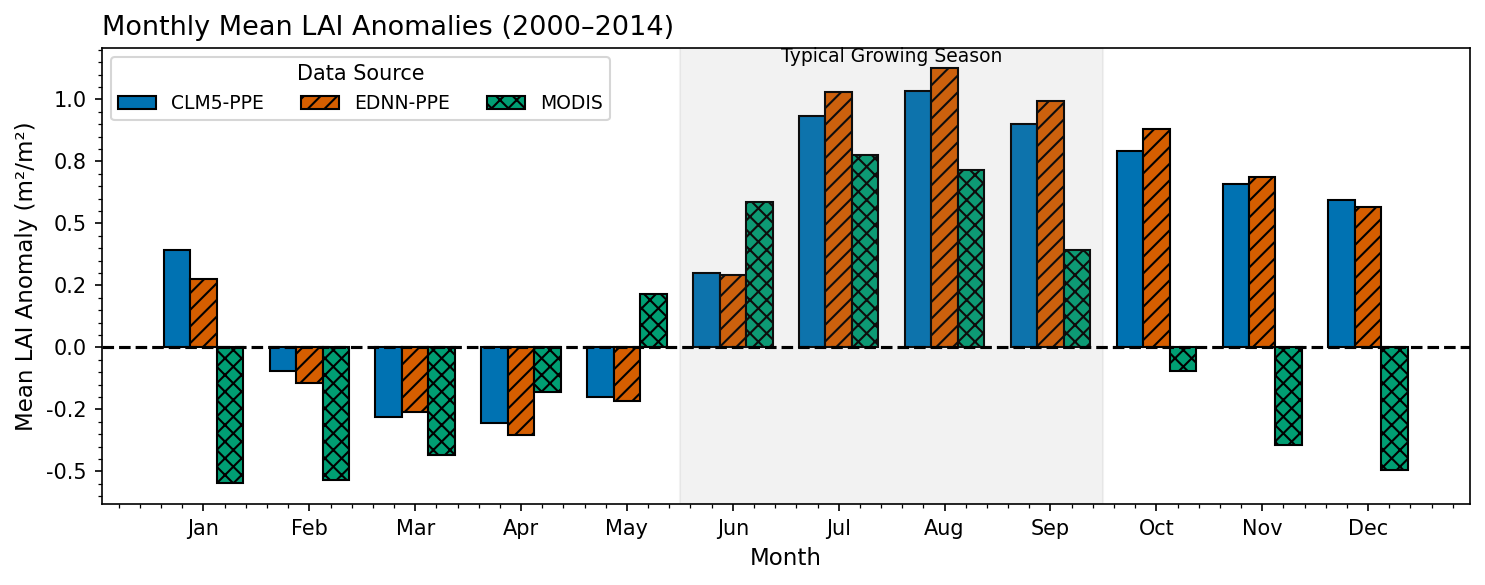

In [16]:
#-------------------------------
# Compute Monthly Means
#-------------------------------
#------------------------------- MODIS: average over all Januaries, Februaries, … Decembers
modis_monthly = ts.groupby('time.month').mean(dim='time')

#------------------------------- CLM5: average over time for each month, then over ensemble members
clm5_monthly = (
    clm5_lai_ppe_anom
    .groupby('time.month')
    .mean(dim='time')
    .mean(dim='member')
)

#------------------------------- EDNN: same procedure
ednn_monthly = (
    ednn_ppe_lai_anom
    .groupby('time.month')
    .mean(dim='time')
    .mean(dim='member')
)

#-------------------------------
# Prepare Plot Data
#-------------------------------
months = np.arange(1, 13)
labels = [calendar.month_abbr[m] for m in months]

clm5_vals  = clm5_monthly.sel(month=months).values
ednn_vals  = ednn_monthly.sel(month=months).values
modis_vals = modis_monthly.sel(month=months).values

x = np.arange(12)
width = 0.25

#------------------------------- Colorblind-friendly palette and hatches
colors = {
    'CLM5': '#0072B2',
    'EDNN': '#D55E00',
    'MODIS':'#009E73'
}
hatches = {
    'CLM5': '',
    'EDNN':'///',
    'MODIS':'xxx'
}

#-------------------------------
# Create Bar Plot
#-------------------------------
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

#------------------------------- CLM5 bars
ax.bar(
    x - width, clm5_vals, width,
    color=colors['CLM5'], edgecolor='black', hatch=hatches['CLM5'],
    label='CLM5-PPE'
)
#------------------------------- EDNN bars
ax.bar(
    x, ednn_vals, width,
    color=colors['EDNN'], edgecolor='black', hatch=hatches['EDNN'],
    label='EDNN-PPE'
)
#------------------------------- MODIS bars
ax.bar(
    x + width, modis_vals, width,
    color=colors['MODIS'], edgecolor='black', hatch=hatches['MODIS'],
    label='MODIS'
)
#------------------------------- Highlight growing season (May to Sep)
ax.axvspan(4.5, 8.5, color='gray', alpha=0.1)
ax.text(
    6.5, ax.get_ylim()[1]*0.95,
    'Typical Growing Season',
    ha='center', fontsize=9
)

#-------------------------------
# Styling
#-------------------------------
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel('Month', fontsize=11)
ax.axhline(0, color='black', linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_ylabel('Mean LAI Anomaly (m²/m²)', fontsize=11)
ax.set_title(
    'Monthly Mean LAI Anomalies (2000–2014)',
    loc='left', fontsize=13
)
ax.legend(
    title='Data Source',
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    framealpha=0.8,
    ncol=3
)
ax.minorticks_on()

#-------------------------------
# Save & Show
#-------------------------------
plt.tight_layout()
plt.savefig(f"{figure_path}/monthly_lai_anomalies_barplot.pdf", bbox_inches='tight')
plt.show()

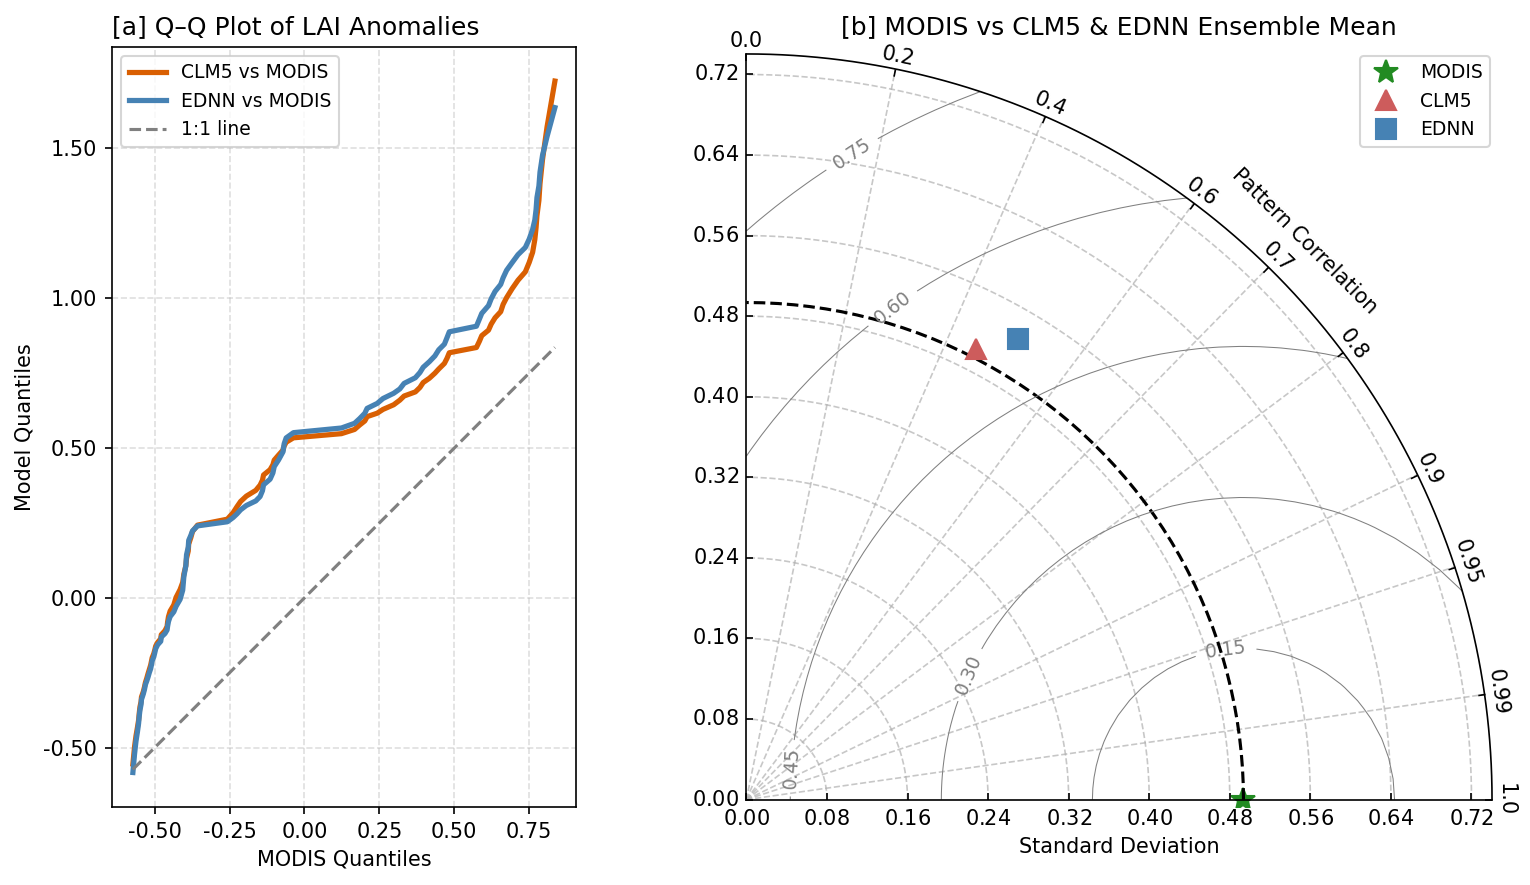

In [17]:
#-------------------------------
# Prepare Quantile Data and KS-Statistics
#-------------------------------
#------------------------------- Flatten anomaly arrays for all members and times
clm5_flat = clm5_lai_ppe_anom.values.flatten()
ednn_flat = ednn_ppe_lai_anom.values.flatten()
modis_flat = ts.values.flatten()

#------------------------------- Define quantile levels and compute quantiles
q = np.linspace(0.01, 0.99, 99)
modis_q = np.quantile(modis_flat, q)
clm5_q   = np.quantile(clm5_flat, q)
ednn_q   = np.quantile(ednn_flat, q)

#------------------------------- Kolmogorov-Smirnov test vs MODIS
D_clm5, p_clm5 = ks_2samp(clm5_flat, modis_flat)
D_ednn, p_ednn = ks_2samp(ednn_flat, modis_flat)

#-------------------------------
# Cell: Compute Taylor Diagram Statistics
#-------------------------------
#------------------------------- Time series across ensemble mean for each dataset
clm5_ts = clm5_lai_ppe_anom.mean(dim='member').values
ednn_ts = ednn_ppe_lai_anom.mean(dim='member').values
obs_ts  = ts.values

#------------------------------- Compute standard deviations and correlations
std_ref   = obs_ts.std(ddof=1)
std_clm5  = clm5_ts.std(ddof=1)
corr_clm5 = corrcoef(obs_ts, clm5_ts)[0, 1]
std_ednn  = ednn_ts.std(ddof=1)
corr_ednn = corrcoef(obs_ts, ednn_ts)[0, 1]

#------------------------------- Pack samples for Taylor diagram
samples = [
    (std_clm5, corr_clm5, 'CLM5'),
    (std_ednn, corr_ednn, 'EDNN')
]

#-------------------------------
# Taylor Diagram Function
#-------------------------------
def create_taylor_diagram(std_ref, samples, title, fig, rect, add_legend=False):
    """
    Build a Taylor diagram comparing sample std-dev and correlation to reference.
    Requires TaylorDiagram class on PYTHONPATH.
    """
    dia = TaylorDiagram(std_ref, fig=fig, rect=rect, label='MODIS', extend=False)
    #------------------------------- Format reference point
    dia.samplePoints[0].set_color('forestgreen')
    dia.samplePoints[0].set_markersize(12)
    #------------------------------- Add each model sample
    markers = ['^', 's']
    colors  = ['indianred', 'steelblue']
    for i, (s, c, name) in enumerate(samples):
        dia.add_sample(s, c,
                       marker=markers[i], ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=name)
    #------------------------------- Add RMS contours
    contours = dia.add_contours(levels=5, colors='0.5', linewidths=0.5)
    fig.axes[0].clabel(contours, inline=1, fontsize=9, fmt='%.2f')
    dia._ax.grid(True, linestyle='--', alpha=0.7)
    dia._ax.set_title(title, loc='center', fontsize=12)
    if add_legend:
        dia._ax.legend(loc='upper right', fontsize=9, frameon=True)
    fig.tight_layout()
    return dia

#-------------------------------
# Create Q–Q and Taylor Plots
#-------------------------------
fig = plt.figure(figsize=(12, 6), dpi=150)

#------------------------------- [a] Q–Q Plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(modis_q, clm5_q,   color='#d95f02', linewidth=2.5, label='CLM5 vs MODIS')
ax1.plot(modis_q, ednn_q,   color='steelblue', linewidth=2.5, label='EDNN vs MODIS')
ax1.plot(modis_q, modis_q,  color='gray', linestyle='--', linewidth=1.5, label='1:1 line')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('MODIS Quantiles', fontsize=10)
ax1.set_ylabel('Model Quantiles', fontsize=10)
ax1.set_title('[a] Q–Q Plot of LAI Anomalies', loc='left', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=9)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#------------------------------- [b] Taylor Diagram
create_taylor_diagram(
    std_ref, samples,
    title='[b] MODIS vs CLM5 & EDNN Ensemble Mean',
    fig=fig, rect=122,
    add_legend=True
)

#------------------------------- Adjust layout and display
plt.tight_layout()
plt.savefig(f"{figure_path}/qq_and_taylor_comparison.pdf", bbox_inches='tight')
plt.show()

# Predictive Uncertainty EDNN Emulations

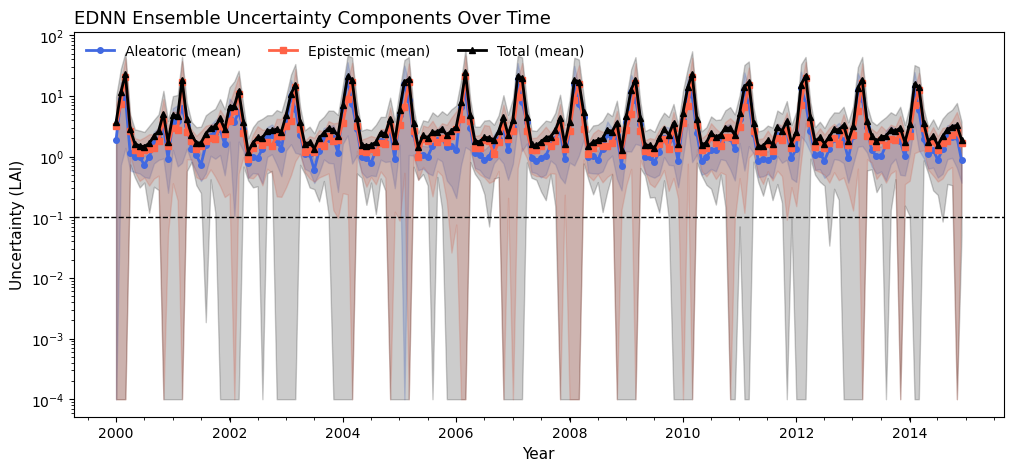

In [21]:
#-------------------------------
# Data Preparation
#-------------------------------
# Extract aleatoric and epistemic uncertainty components
ale = pred_val_3d.TLAI_unc.sel(uncertainty='aleatoric')
epi = pred_val_3d.TLAI_unc.sel(uncertainty='epistemic')

#------------------------------- Compute ensemble means and standard deviations across members
ale_mean = ale.mean(dim='member')
ale_std  = ale.std(dim='member')
epi_mean = epi.mean(dim='member')
epi_std  = epi.std(dim='member')

#------------------------------- Total uncertainty: root-sum-square of component means, sum of stds
total_mean = np.sqrt(ale_mean**2 + epi_mean**2)
total_std  = ale_std + epi_std

#------------------------------- Prevent negative lower bounds for log scale
lower_clip  = 1e-4
ale_lower   = np.clip(ale_mean - ale_std, lower_clip, None)
epi_lower   = np.clip(epi_mean - epi_std, lower_clip, None)
total_lower = np.clip(total_mean - total_std, lower_clip, None)

#-------------------------------
# Plot Uncertainty Time Series (Log Scale)
#-------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

#------------------------------- Aleatoric uncertainty
ax.plot(
    time_idx, ale_mean,
    label='Aleatoric (mean)',
    color='royalblue',
    linewidth=2,
    marker='o',
    markersize=4
)
ax.fill_between(
    time_idx,
    ale_lower,
    ale_mean + ale_std,
    color='royalblue',
    alpha=0.2
)

#------------------------------- Epistemic uncertainty
ax.plot(
    time_idx, epi_mean,
    label='Epistemic (mean)',
    color='tomato',
    linewidth=2,
    marker='s',
    markersize=4
)
ax.fill_between(
    time_idx,
    epi_lower,
    epi_mean + epi_std,
    color='tomato',
    alpha=0.2
)

#------------------------------- Total uncertainty
ax.plot(
    time_idx, total_mean,
    label='Total (mean)',
    color='black',
    linewidth=2,
    marker='^',
    markersize=4
)
ax.fill_between(
    time_idx,
    total_lower,
    total_mean + total_std,
    color='black',
    alpha=0.2
)

#------------------------------- Logarithmic y-axis
ax.set_yscale('log')

#------------------------------- Reference line, labels, title, and legend
ax.axhline(1e-1, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Uncertainty (LAI)', fontsize=11)
ax.set_title(
    'EDNN Ensemble Uncertainty Components Over Time',
    fontsize=13,
    loc='left'
)
ax.legend(loc='upper left', fontsize=10, ncol=3, frameon=False)
ax.minorticks_on()

# ------------------------------- Save figure\ nplt.tight_layout()
plt.savefig(f"{figure_path}/uncertainty_timeseries_log.pdf", bbox_inches='tight')
plt.show()